In [4]:
import os
fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname, 'r') as f:
    data = f.read()
    
lines = data.splitlines()
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [5]:
import numpy as np
temperature = np.zeros((len(lines), ))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    temperature[i] = values [1]
    raw_data[i, :] = values[:]

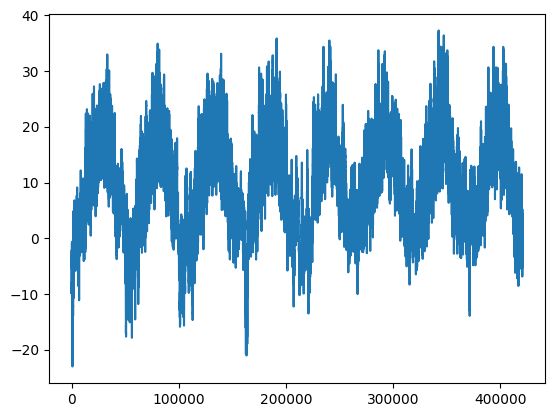

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

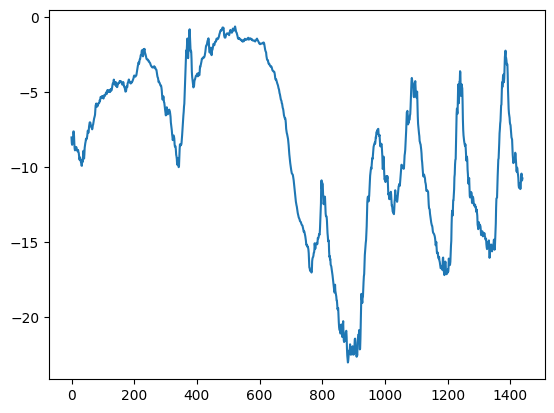

In [7]:
plt.plot(range(1440), temperature[:1440])

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print(num_train_samples, num_val_samples, num_test_samples)

210225 105112 105114


In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
std = raw_data[:num_train_samples].std(axis=0)
raw_data -= mean
raw_data /= std

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 -1)
batch_size = 256

In [12]:
from tensorflow import keras

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
)

In [58]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, target in dataset:
        preds = samples [:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - target))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

In [59]:
val_mae = evaluate_naive_method(val_dataset)
test_mae = evaluate_naive_method(test_dataset)
print('Naive VAL MAE: {:.4f}'.format(val_mae))
print('Naive TEST MAE: {:.4f}'.format(test_mae))

Naive VAL MAE: 2.4417
Naive TEST MAE: 2.6220


In [16]:
from tensorflow.keras import layers

In [60]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [keras.callbacks.ModelCheckpoint('jena_dense.keras', save_best_only=True)]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 4s 4ms/step - loss: 12.6727 - mae: 2.7593 - val_loss: 10.1606 - val_mae: 2.5047
Epoch 2/10
819/819 [==============================] - 3s 4ms/step - loss: 9.1682 - mae: 2.3839 - val_loss: 9.9570 - val_mae: 2.4835
Epoch 3/10
819/819 [==============================] - 3s 4ms/step - loss: 8.4917 - mae: 2.2919 - val_loss: 10.2862 - val_mae: 2.5326
Epoch 4/10
819/819 [==============================] - 3s 4ms/step - loss: 8.0057 - mae: 2.2268 - val_loss: 10.6991 - val_mae: 2.5922
Epoch 5/10
819/819 [==============================] - 3s 4ms/step - loss: 7.6735 - mae: 2.1799 - val_loss: 11.4795 - val_mae: 2.6919
Epoch 6/10
819/819 [==============================] - 3s 4ms/step - loss: 7.4412 - mae: 2.1454 - val_loss: 12.8069 - val_mae: 2.8402
Epoch 7/10
819/819 [==============================] - 3s 4ms/step - loss: 7.2096 - mae: 2.1116 - val_loss: 13.3709 - val_mae: 2.9280
Epoch 8/10
819/819 [==============================] - 3s 4ms/step - l

In [61]:
model = keras.models.load_model('jena_dense.keras')
test_mae = model.evaluate(test_dataset)[1]

405/405 [==============================] - 1s 3ms/step - loss: 10.8501 - mae: 2.5979


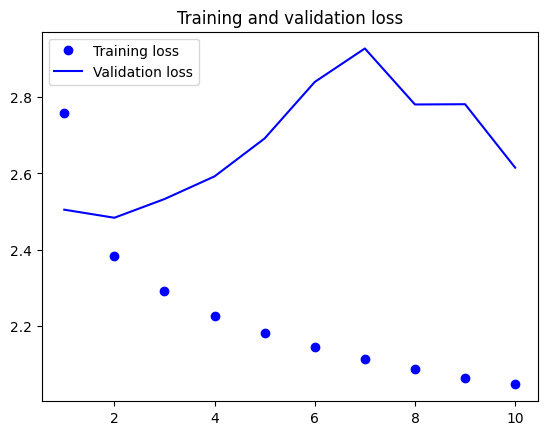

In [62]:
loss = history.history['mae']
val_loss = history.history['val_mae']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [63]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation='relu')(inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(8, 12, activation='relu')(x)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(8, 6, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [64]:
callbacks = [keras.callbacks.ModelCheckpoint('jena_conv.keras', save_best_only=True)]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 4s 4ms/step - loss: 23.1428 - mae: 3.7607 - val_loss: 14.7606 - val_mae: 3.0420
Epoch 2/10
819/819 [==============================] - 3s 4ms/step - loss: 15.0914 - mae: 3.0867 - val_loss: 14.9238 - val_mae: 3.0346
Epoch 3/10
819/819 [==============================] - 3s 4ms/step - loss: 13.6840 - mae: 2.9293 - val_loss: 14.9134 - val_mae: 3.0721
Epoch 4/10
819/819 [==============================] - 3s 4ms/step - loss: 12.9347 - mae: 2.8478 - val_loss: 14.3331 - val_mae: 2.9782
Epoch 5/10
819/819 [==============================] - 3s 4ms/step - loss: 12.3837 - mae: 2.7833 - val_loss: 13.8686 - val_mae: 2.9229
Epoch 6/10
819/819 [==============================] - 3s 4ms/step - loss: 11.9918 - mae: 2.7421 - val_loss: 14.5691 - val_mae: 3.0290
Epoch 7/10
819/819 [==============================] - 4s 4ms/step - loss: 11.6266 - mae: 2.6993 - val_loss: 15.1340 - val_mae: 3.0710
Epoch 8/10
819/819 [==============================] - 3s 4ms/s

In [65]:
model = keras.models.load_model('jena_dense.keras')
test_mae = model.evaluate(test_dataset)

405/405 [==============================] - 1s 3ms/step - loss: 10.8501 - mae: 2.5979


In [66]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [keras.callbacks.ModelCheckpoint('jena_lstm.keras', save_best_only=True)]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 6s 7ms/step - loss: 42.5970 - mae: 4.7503 - val_loss: 13.3518 - val_mae: 2.7481
Epoch 2/10
819/819 [==============================] - 6s 7ms/step - loss: 10.9411 - mae: 2.5685 - val_loss: 9.6653 - val_mae: 2.4225
Epoch 3/10
819/819 [==============================] - 6s 7ms/step - loss: 9.5721 - mae: 2.4187 - val_loss: 9.6923 - val_mae: 2.4399
Epoch 4/10
819/819 [==============================] - 6s 7ms/step - loss: 9.1448 - mae: 2.3607 - val_loss: 9.7216 - val_mae: 2.4296
Epoch 5/10
819/819 [==============================] - 5s 7ms/step - loss: 8.7592 - mae: 2.3090 - val_loss: 9.6443 - val_mae: 2.4208
Epoch 6/10
819/819 [==============================] - 5s 7ms/step - loss: 8.4069 - mae: 2.2638 - val_loss: 10.4465 - val_mae: 2.5257
Epoch 7/10
819/819 [==============================] - 5s 7ms/step - loss: 8.0991 - mae: 2.2232 - val_loss: 10.0703 - val_mae: 2.4794
Epoch 8/10
819/819 [==============================] - 5s 7ms/step - los

In [67]:
model = keras.models.load_model('jena_lstm.keras')
test_mae = model.evaluate(test_dataset)

405/405 [==============================] - 2s 3ms/step - loss: 10.8858 - mae: 2.5943


In [82]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]), batch_size=256)
x = layers.LSTM(32, recurrent_dropout=0.2)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [83]:
callbacks = [keras.callbacks.ModelCheckpoint('jena_lstm_dropout.keras', save_best_only=True)]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks, batch_size=256)

Epoch 1/50


ValueError: in user code:

    File "/home/nacho/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/nacho/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nacho/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/nacho/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/nacho/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/nacho/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/backend.py", line 4856, in rnn
        raise ValueError("Unrolling requires a fixed number of timesteps.")

    ValueError: Exception encountered when calling layer 'lstm_23' (type LSTM).
    
    Unrolling requires a fixed number of timesteps.
    
    Call arguments received by layer 'lstm_23' (type LSTM):
      • inputs=tf.Tensor(shape=(None, None, 14), dtype=float32)
      • mask=None
      • training=True
      • initial_state=None


In [84]:
model = keras.models.load_model('jena_lstm_dropout.keras')

In [85]:
model.evaluate(test_dataset)

405/405 [==============================] - 10s 24ms/step - loss: 10.2067 - mae: 2.5150


[10.2066650390625, 2.5150020122528076]

In [88]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint('jena_stacked_gru_drouput.keras', save_best_only=True)]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)

In [14]:
model = keras.models.load_model('jena_stacked_gru_drouput.keras')
model.evaluate(test_dataset)

405/405 [==============================] - 9s 21ms/step - loss: 9.9673 - mae: 2.4798


[9.967337608337402, 2.479792833328247]

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [18]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
  1/819 [..............................] - ETA: 23:46 - loss: 150.3854 - mae: 10.2752

2023-12-27 17:23:17.113503: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-27 17:23:17.154678: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-27 17:23:17.155273: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-27 17:23:17.155397: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-27 17:23:17.156582: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2023-12-27 17:23:17.156983: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kern

819/819 [==============================] - 11s 11ms/step - loss: 29.9818 - mae: 3.9147 - val_loss: 10.5318 - val_mae: 2.4996
Epoch 2/10
819/819 [==============================] - 9s 11ms/step - loss: 9.6954 - mae: 2.4305 - val_loss: 9.8201 - val_mae: 2.4146
Epoch 3/10
819/819 [==============================] - 9s 11ms/step - loss: 8.8752 - mae: 2.3149 - val_loss: 9.9487 - val_mae: 2.4258
Epoch 4/10
819/819 [==============================] - 9s 11ms/step - loss: 8.3409 - mae: 2.2455 - val_loss: 10.1825 - val_mae: 2.4397
Epoch 5/10
819/819 [==============================] - 9s 10ms/step - loss: 7.8085 - mae: 2.1760 - val_loss: 10.2988 - val_mae: 2.4369
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 7.4164 - mae: 2.1231 - val_loss: 10.6419 - val_mae: 2.4677
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 7.0514 - mae: 2.0734 - val_loss: 11.0907 - val_mae: 2.5382
Epoch 8/10
819/819 [==============================] - 9s 11ms/step - loss

In [19]:
model.evaluate(test_dataset)

405/405 [==============================] - 2s 4ms/step - loss: 12.8994 - mae: 2.7853


[12.8993558883667, 2.785325050354004]